### Import packages

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             
from numpy.random import choice

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [2]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lijnennieuw.csv", sep=";")

# Convert columns to lst type\
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(str(x).replace(',','.')))
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(str(x).replace(',','.')))

In [3]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"], 
                          row["Start1"], row["Start2"], row["Frequency"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [4]:
# Create graph
FG = nx.MultiDiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

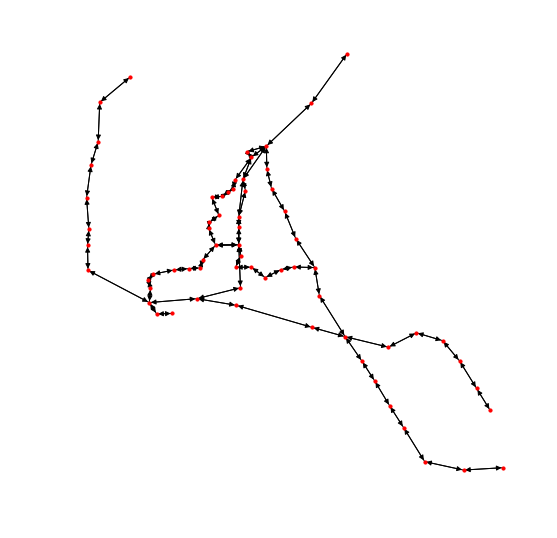

In [5]:
# Plot the network
plt.figure(figsize=(7,7)) 
# nx.draw(FG, positions, node_size=10, with_labels=True, font_size=10)
nx.draw(FG, positions, node_size=10)

### Route calculation and choice functions

In [10]:
origin = 'Amstelstation'
destination = 'De Pijp'

paths = nx.all_simple_paths(FG, source = origin, target = destination)    
    
routes = []
for path in paths:
    routes.append(((route_calculation(path, FG)), path))
    
routes2 = [route[0] for route in routes if route[0]['transfers'] <= 2]

In [9]:
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr[0]['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr[0]['line']
                route_info["lines"].append(line) 
        
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr[0]['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr[0]['duration']
        
    route_info["waiting"] = int(random.random() * 10)
    route_info["duration"] += (route_info["transfers"] * 3)
    
    return route_info

In [31]:
from datetime import timedelta
simulation_start = datetime.datetime(2018, 1, 1, 6, 0)
print(simulation_start + timedelta(minutes=10))

2018-01-01 06:10:00


In [31]:
def calculate_schedule(lines, simhours, start):
    simulation_end = simulation_start + timedelta(hours = simhours)
    schedule = {}
    
    for line in lines:
        print(lines[line])
    
    
calculate_schedule(lines, 19, datetime.datetime(2018, 1, 1, 6, 0))

(['Noord', 'Noorderpark', 'Centraal Station', 'Rokin', 'Vijzelgracht', 'De Pijp', 'Europaplein', 'Station Zuid'], ['Station Zuid', 'Europaplein', 'De Pijp', 'Vijzelgracht', 'Rokin', 'Centraal Station', 'Noorderpark', 'Noord'], [2, 2, 2, 2, 2, 2, 3], 0, 5, 6)
(['Centraal Station', 'Dam', 'Rokin', 'Muntplein', 'Vijzelgracht', 'Marie Heinekenplein', 'De Pijp', 'Roelof Hartplein', 'Gerrit v.d. Veenstraat', 'Beethovenstraat', 'Minervaplein', 'Olympiaplein', 'Olympiaweg', 'Olympisch stadion', 'IJsbaanpad', 'Amstelveenseweg', 'VU medisch centrum', 'De Boelelaan/VU'], ['De Boelelaan/VU', 'VU medisch centrum', 'Amstelveenseweg', 'IJsbaanpad', 'Olympisch stadion', 'Olympiaweg', 'Olympiaplein', 'Minervaplein', 'Beethovenstraat', 'Gerrit v.d. Veenstraat', 'Roelof Hartplein', 'De Pijp', 'Marie Heinekenplein', 'Vijzelgracht', 'Muntplein', 'Rokin', 'Dam', 'Centraal Station'], [3, 2, 1, 3, 1, 2, 3, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2], 5, 4, 10)
(['Centraal Station', 'Nieuwezijds Kolk', 'Dam', 'Spui', 'Konin

In [32]:
def route_choice(env, routes, classname):
    if classname == 0:
        minimum = routes[0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i]["duration"] < minimum:
                minimum = routes[i]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i]["duration"] == minimum:
                if routes[i]["transfers"] < routes[index]["transfers"]:
                    index = i

#     elif classname == 1:
#         minimum = routes[0]["waiting"]
#         index = 0
#         for i in range(1, len(routes)):
#             # Loop through all routes and save the route with the least waiting time
#             if routes[i]["waiting"] < minimum:
#                 minimum = routes[i]["waiting"]
#                 index = i

#             # If waiting time is the same, save the route with the shortest duration
#             elif routes[i]["waiting"] == minimum:
#                 if routes[i]["duration"] < routes[index]["duration"]:
#                     index = i

#     elif classname == 2:
#         minimum = routes[0]["transfers"]
#         index = 0
#         for i in range(1, len(routes)):
#             # Loop through all routes and save the route with the least transfers
#             if routes[i]["transfers"] < minimum:
#                 minimum = routes[i]["transfers"]
#                 index = i

#             # If the num of transfers is the same, save the route with the shortes duration
#             elif routes[i]["transfers"] == minimum:
#                 if routes[i]["duration"] < routes[index]["duration"]:
#                     index = i
                    
    return routes[index]

### Create and spawn vehicles

In [8]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

In [23]:
def vehicle(env, name, direction):
    yield env.timeout(env.lines[name][5] * 60)
    while True:
        vehicle = generate_vehicle(env.lines[name][direction], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(frequency * 60)

### Generate passengers based on data

In [10]:
origin = pd.read_csv("Data/origin.csv")
destination = pd.read_csv("Data/destination.csv")

gvborigin = {}
gvbdestination = {}

hours = list(set(origin['hour'].tolist()))

for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvborigin[hour[:2]] = (total, stops, percentages)
    
for hour in hours:
    df = destination[destination['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvbdestination[hour[:2]] = (total, stops, percentages)

In [28]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        routes.append(((route_calculation(path, environment.FG)), path))
     
    # Remove routes with more than 2 transfers to reduce computation
    routes = [route[0] for route in routes if route[0]['transfers'] <= 2]
    
    # Travel direction and route information
    route_info, route = route_choice(environment, routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [12]:
def passengers(env, classname, origindata, destinationdata):
    # Store number of passengers, origin data and destination data
    # for the hour in a variable
    hour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
    numpassengers = origindata[hour][0]
    originstations = origindata[hour][1]
    originprobabilities = origindata[hour][2]
    
    destinationstations = destinationdata[hour][1]
    destinationprobabilities = destinationdata[hour][2]

    while True:
        newhour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
        if newhour == hour:
            origin = (choice(originstations, 1, p=originprobabilities))[0]
            destination = (choice(destinationstations, 1, p=destinationprobabilities))[0]
            
            # Run again if origin and destination are the same
            while origin == destination:
                origin = choice(originstations, 1, p=originprobabilities)[0]
                destination = choice(destinationstations, 1, p=destinationprobabilities)[0]

            # Create passenger and add to simulation
            passenger = generate_passenger(origin, destination, classname, env)
            FG.nodes[origin]["object_type"].units.append(passenger)
            passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                                env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
            env.passengers.append(passenger)

            # Calculate timeout based on arrival rate
            timeout = (60*60) / numpassengers
            yield env.timeout(timeout)
            
        # If the hour is exceeded, update variables for the next hour
        else:
            hour = newhour
            numpassengers = origindata[hour][0]
            originstations = origindata[hour][1]
            originprobabilities = origindata[hour][2]

            destinationstations = destinationdata[hour][1]
            destinationprobabilities = destinationdata[hour][2]

### Run simulation

In [16]:
%%time
# Simulation start time
simulationhours = 19
simulation_start = datetime.datetime(2018, 1, 1, 6, 0)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []
env.lines = lines
env.schedule = calculate_schedule(lines, simulationhours, simulation_start)

 + timedelta(minutes=10)
    env.now + 19 * 60 * 60


# Start the simulation
for line in env.lines.keys():
    env.process(vehicle(env, line, 0))
    env.process(vehicle(env, line, 1))

env.process(passengers(env, 0, gvborigin, gvbdestination))
env.run(until = env.now + simulationhours * 60 * 60)

CPU times: user 1h 7min 4s, sys: 21.6 s, total: 1h 7min 25s
Wall time: 1h 9min 20s


### Check results

In [17]:
len(env.passengers)

265191

### Store passenger and vehicle data

In [20]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
            passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route,
                                        "origin": env.passengers[i].route[0],
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'],
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id,
                                        "waiting_time": 0}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
# passengerdf.to_csv("Results/passengers.csv", index=True)
passengerdf.head()

,arrival,class_id,creation,date,departure,destination,lines,origin,route,transfers,transferstations,waiting_time
3e0269f6-7ed2-11e9-9619-7831c1d08f6a,06:30:00,0,06:00:00,2018-01-01,06:07:00,Bullewijk,[metro54],Centraal Station,"[Centraal Station, Nieuwmarkt, Waterlooplein, ...",0,[],0
3e051908-7ed2-11e9-9210-7831c1d08f6a,06:18:30,0,06:00:00,2018-01-01,06:11:00,Station Zuid,"[metro54, metro51]",Waterlooplein,"[Waterlooplein, Weesperplein, Wibautstraat, Am...",1,[Spaklerweg],0
3e054450-7ed2-11e9-a965-7831c1d08f6a,06:14:30,0,06:00:01,2018-01-01,06:11:00,Station Bijlmer ArenA,[metro54],Station Holendrecht,"[Station Holendrecht, Bullewijk, Station Bijlm...",0,[],0
3e107a5a-7ed2-11e9-ba26-7831c1d08f6a,06:18:30,0,06:00:02,2018-01-01,06:17:30,Station Sloterdijk,"[metro54, metro51]",Amstelstation,"[Amstelstation, Spaklerweg, Overamstel, Statio...",1,[Spaklerweg],0
3e11af06-7ed2-11e9-ad86-7831c1d08f6a,06:42:00,0,06:00:03,2018-01-01,06:30:00,Amstelstation,[tram12],De Pijp,"[De Pijp, Cornelis Troostplein, Scheldestraat,...",0,[],0


In [22]:
passengerdf.to_csv("Results/passengers.csv", index=True)

In [21]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("Results/vehicles.csv", index=True)
vehicledf

,arrival,date,departure,line,route
3e027868-7ed2-11e9-9e12-7831c1d08f6a,06:43:00,2018-01-01,06:00:00,metro50,"[Gein, Reigersbos, Station Holendrecht, Bullew..."
3e028768-7ed2-11e9-8875-7831c1d08f6a,06:38:30,2018-01-01,06:00:00,metro51,"[Centraal Station, Nieuwmarkt, Waterlooplein, ..."
3e0298cc-7ed2-11e9-8dd0-7831c1d08f6a,06:18:00,2018-01-01,06:00:00,metro52,"[Noord, Noorderpark, Centraal Station, Rokin, ..."
3ef5f90c-7ed2-11e9-805a-7831c1d08f6a,06:44:00,2018-01-01,06:01:00,metro50,"[Isolatorweg, Station Sloterdijk, Burg.de Vlug..."
407a481e-7ed2-11e9-b67b-7831c1d08f6a,06:30:00,2018-01-01,06:03:00,metro53,"[Gaasperplas, Kraaienneststation, Station Ganz..."
407a5d58-7ed2-11e9-9e70-7831c1d08f6a,06:30:00,2018-01-01,06:03:00,metro53,"[Centraal Station, Nieuwmarkt, Waterlooplein, ..."
407a708c-7ed2-11e9-8ce6-7831c1d08f6a,06:40:00,2018-01-01,06:03:00,tram12,"[Amstelstation, Amsteldijk, Victorieplein, Waa..."
410fe498-7ed2-11e9-8132-7831c1d08f6a,06:42:00,2018-01-01,06:04:00,tram24,"[De Boelelaan/VU, VU medisch centrum, Amstelve..."
41aa7c68-7ed2-11e9-9a3c-7831c1d08f6a,06:23:00,2018-01-01,06:05:00,metro52,"[Station Zuid, Europaplein, De Pijp, Vijzelgra..."
41aa8e80-7ed2-11e9-876a-7831c1d08f6a,06:42:00,2018-01-01,06:05:00,tram12,"[Centraal Station, Nieuwezijds Kolk, Dam, Spui..."
